In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import os
import time
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm

### Merge meta information

## Figure 1: Fish plot

**Data path** (after fixing a bug with `pypdf` on Oct. 6th)
```
/eagle/projects/argonne_tpc/siebenschuh/aurora_gpt/database/FINAL_TABLES/FINAL_FINAL_meta_and_metrics_only.csv
```

**Origin story**:
Parse ~25k PDF with various parsers, compute BLEU etc. score with HTML `groundtruth`. Sort PDFs by difficulty to parse (collectively decided by average BLEU score), this determines lication on the x-axis. y-axis each parser's BLEU score. 

**Takeaway**
- Parser performance (collectivley) depends on the PDF at hand: parser accuracies are **not** uncorrelated for a given PDF
- Some parsers dominate others across almost all PDFs; then again, some parsers 



In [2]:
%%time

# = = = = = = = = = = 
# Load dataframe
# = = = = = = = = = = 
read_manually = True
subset_to_10k = False

if read_manually:
    # path to BLEU etc.
    p = Path('/lus/eagle/projects/argonne_tpc/siebenschuh/aurora_gpt/database/FINAL_FINAL_meta_and_metrics_only.csv')
    
    # exclude text-columns (not necessary, already loading DF without text columns `meta_and_metrics_only`
    #headers = [*pd.read_csv(p, sep='|', nrows=1)]
    #df = pd.read_csv(p, sep='|', usecols=[c for c in headers if c not in {'html', 'nougat', 'pymupdf', 'grobid', 'pypdf', 'marker', 'tesseract'}])

    # load
    df = pd.read_csv(p, sep='|')

    if subset_to_10k:
        # load subset indices (10_240)
        df_10240 = pd.read_csv('/eagle/projects/argonne_tpc/siebenschuh/aurora_gpt/database/scaling_data/frames/df_orig_10240.csv', sep='|')
        
        # subset
        df_subset = df[df['path'].isin(df_10240['path'])]
        df = df_subset.copy()
else:
    df = pd.read_csv('./frames/meta_frame.csv', sep='|')

CPU times: user 80.8 ms, sys: 95.7 ms, total: 176 ms
Wall time: 240 ms


In [11]:
set(df['subcategory'])

{'Acoustics',
 'Aerospace Engineering',
 'Algebra',
 'Algorithms',
 'Analysis',
 'Analytical Chemistry',
 'Applied Mathematics',
 'Architecture',
 'Artificial Intelligence',
 'Astronomy',
 'Astrophysics',
 'Behavioral Economics',
 'Biochemistry',
 'Bioinformatics',
 'Biophysics',
 'Biotechnology',
 'Calculus',
 'Cardiology',
 'Cardiovascular Medicine',
 'Cell Biology',
 'Chemical Engineering',
 'Civil Engineering',
 'Classical Mechanics',
 'Combinatorics',
 'Condensed Matter Physics',
 'Cybersecurity',
 'Data Science',
 'Data Structures',
 'Development Economics',
 'Discrete Mathematics',
 'Econometrics',
 'Electromagnetism',
 'Environmental Engineering',
 'Epidemiology',
 'Evolutionary Biology',
 'Financial Economics',
 'Genetics',
 'Geometry',
 'Human-Computer Interaction',
 'Immunology',
 'Machine Learning',
 'Macroeconomics',
 'Materials Science and Engineering',
 'Mathematical Logic',
 'Microbiology',
 'Molecular Biology',
 'Natural Language Processing',
 'Neurology',
 'Neuroscien

In [12]:
acoustics to zoology

SyntaxError: invalid syntax (3736934471.py, line 1)

In [15]:
def plot_smoothed_bleu_scores(df, 
                              q=0.1, 
                              smooth_val:int=50, 
                              num_parsers:int=6,
                              score_name:str='bleu',
                              normalized_flag:bool=False,
                              alpha:float=0.3,
                              smooth_factor:float = 2.0,
                              save_flag:bool=False,
                              path_to_font = './fonts/TimesNewRoman.ttf'):

    # Create a FontProperties object
    assert Path(path_to_font).is_file(), f"Assume the path to font you provided is correct. Invalid: {path_to_font}"
    font_prop = fm.FontProperties(fname=path_to_font, size=18)
    
    # Set columns based on normalization flag
    score_columns = {
        'nougat': f"{score_name}_nougat{'_norm' if normalized_flag else ''}",
        'pymupdf': f"{score_name}_pymupdf{'_norm' if normalized_flag else ''}", 
        'grobid': f"{score_name}_grobid{'_norm' if normalized_flag else ''}", 
        'marker': f"{score_name}_marker{'_norm' if normalized_flag else ''}", 
        'pypdf': f"{score_name}_pypdf{'_norm' if normalized_flag else ''}", 
        'tesseract': f"{score_name}_tesseract{'_norm' if normalized_flag else ''}", 
    }
    # all score names
    all_score_names = [c for c in df.columns if ('bleu' in c) or ('rouge' in c) or ('car' in c)]
    
    # Select the relevant parser columns
    parsers = list(score_columns.values())[:num_parsers]
    #          bleu        orange     green     red      pink     grey
    colors = ['#0081FB', '#ffa500', 'green', '#db0404', 'pink', '#c5c5c5'][:num_parsers]  # Limit to the number of parsers

    # Fill NaNs to avoid issues in plotting (could also use dropna if appropriate)
    df[parsers] = df[parsers].interpolate()

    # Compute means
    sort_relevant_columns = [c for c in score_columns.values() if ('pypdf' not in c) and ('nougat' not in c)]
    #print(sort_relevant_columns)
    df[f'bleu_mean'] = df[sort_relevant_columns].mean(axis=1)

    # Step 1: Sort the DataFrame by 'bleu_norm_mean' in descending order
    df_sorted = df.sort_values(by=f'{score_name}_mean', ascending=False).reset_index(drop=True)

    
    # Step 2: Apply a rolling mean to smooth the time series
    df_smoothed = df_sorted[parsers].rolling(window=smooth_val, min_periods=1).mean()

    # smooth pypdf more
    #df_smoothed[score_columns['pypdf']] = df_smoothed[score_columns['pypdf']].rolling(window=150, min_periods=1).mean()
    
    # Step 3: calculate the rolling quantiles as naïve upper/lower ends for confidence bands
    df_lower = df_sorted[parsers].rolling(window=round(smooth_val * smooth_factor), min_periods=1).quantile(q)
    df_upper = df_sorted[parsers].rolling(window=round(smooth_val * smooth_factor), min_periods=1).quantile(1 - q)

    # Step 4: calculate the distances from the smoothed values to the quantiles
    for parser_column in parsers:
        # Compute distance between smoothed value and lower/upper quantile
        distance_lower = df_smoothed[parser_column] - df_lower[parser_column]
        distance_upper = df_upper[parser_column] - df_smoothed[parser_column]
        
        # Step 5: Symmetrize the confidence bands around the smoothed value
        max_distance = pd.concat([distance_lower, distance_upper], axis=1).max(axis=1)
        
        # New bounds centered around the smoothed value
        df_lower[parser_column] = df_smoothed[parser_column] - max_distance
        df_upper[parser_column] = df_smoothed[parser_column] + max_distance

    # Step 3: Plot the smoothed time series with confidence bands
    plt.figure(figsize=(11, 8))

    # Step X: Determine order of graphs
    order = ['tesseract', 'nougat', 'marker', 'pypdf', 'grobid', 'marker', 'pymupdf']
    parsers_and_colors = sorted(zip(parsers, colors), key=lambda x: next(i for i, substr in enumerate(order) if substr in x[0]))
    parsers_sorted, colors_sorted = zip(*parsers_and_colors)
    
    # Plotting with colors
    lines = []
    for parser_column, col in zip(parsers_sorted, colors_sorted):
        line, = plt.plot(df_smoothed.index, 
                         df_smoothed[parser_column], 
                         label=parser_column, 
                         color=col,
                         linewidth=3.0)
        plt.fill_between(df_smoothed.index, df_lower[parser_column], df_upper[parser_column], color=col, alpha=alpha, label='_nolegend_')
        lines.append(line)

    # Adding labels and title
    font_prop.set_size(22)
    plt.xlabel('PDFs sorted by average BLEU score across parsers', fontsize=24, labelpad=6, fontproperties=font_prop)
    plt.ylabel(f'{score_name.upper()} score', labelpad=6, fontsize=24, fontproperties=font_prop)

    # Conditionally set the title
    #if normalized_flag:
    #    plt.title(f'Smoothed {score_name.upper()} Scores by Method with Confidence Bands')
    #else:
    #    plt.title(f'Smoothed {score_name.upper()} Scores of Normalized Text by Method with Confidence Bands')

    # LEGEND
    order = ['Nougat', 'Marker', 'PyMuPDF', 'Tesseract', 'GROBID', 'pypdf']
    
    # score_columns `pypdf` : `pypdf_bleu_norm`
    handles_labels = {line.get_label(): line for line in lines}  # Create a mapping of labels to line handles
    #print(handles_labels)
    handles = [handles_labels[score_columns[label.lower()]] for label in order]  # Get handles in the desired order

    # Step 4: Use plt.legend() with the correct order
    font_prop.set_size(22)
    plt.legend(handles, order, prop=font_prop)

    # Step 5: Modify axes
    # - unify font style
    font_prop.set_size(22)
    plt.yticks(fontproperties=font_prop)
    plt.xticks(fontproperties=font_prop)
    # - add ticks 
    plt.gca().set_xticklabels([])
    plt.xlim(-20, len(df) + 20)
    # - y axis
    plt.ylim(0.0, 1.0)
    plt.tick_params(axis='y')

    # adjust margins (white padding) around actual plot
    plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1)
    
    # save
    if save_flag:
        if not os.path.exists('saved_plots'):
            os.makedirs('saved_plots')

        # define the file name using the current time
        file_name = f'saved_plots/Fishplot_{round(time.time())}.png'

        # save the plot to the specified location
        plt.savefig(file_name, dpi=300)

        # msg
        print('Saved!')

    # Show the plot
    plt.show()

In [16]:
len(df)

23398

Saved!


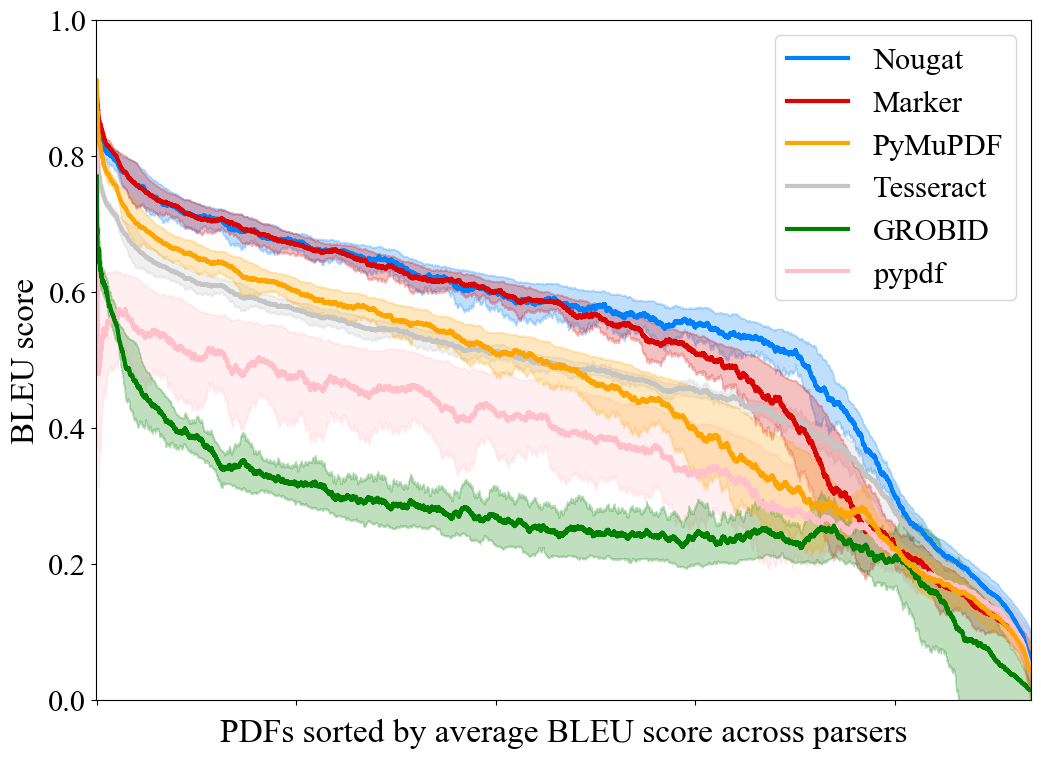

In [19]:
plot_smoothed_bleu_scores(df, q=0.45, smooth_val=500, num_parsers=6, 
                          normalized_flag=True, score_name='bleu', 
                          alpha=0.25,
                          save_flag=True)

In [ ]:
# encode how parser names are written
name_dict = {'nougat' : 'Nougat', 'pymupdf' : 'PyMuPDF', 'grobid' : 'GROBID', 'marker' : 'Marker', 
             'tesseract' : 'Tesseract', 'pypdf' : 'pypdf'}

# THIS MEASURES THE SUCCESS RATE (PLEASE ADD AS FIRST COLUMN)
# col names
colnames = [name_dict[c.split('_')[1]] for c in score_columns]
# column: success rate
bomb_frequencies = (df[score_columns] < 0.05).mean()
success_rate = {c : 1.-f for c,f in  zip(colnames, bomb_frequencies)}

# loop
all_score_lists = [['bleu_nougat_norm',
  'bleu_pymupdf_norm',
  'bleu_grobid_norm',
  'bleu_marker_norm',
  'bleu_tesseract_norm',
  'bleu_pypdf_norm'],
 ['rouge_nougat_norm',
  'rouge_pymupdf_norm',
  'rouge_grobid_norm',
  'rouge_marker_norm',
  'rouge_tesseract_norm',
  'rouge_pypdf_norm'],
 ['car_nougat_norm',
  'car_pymupdf_norm',
  'car_grobid_norm',
  'car_marker_norm',
  'car_tesseract_norm',
  'car_pypdf_norm']]

# Lists for BLEU, ROUGE, and CAR columns
bleu_list = ['bleu_nougat_norm', 'bleu_pymupdf_norm', 'bleu_grobid_norm', 'bleu_marker_norm', 'bleu_tesseract_norm', 'bleu_pypdf_norm']
rouge_list = ['rouge_nougat_norm', 'rouge_pymupdf_norm', 'rouge_grobid_norm', 'rouge_marker_norm', 'rouge_tesseract_norm', 'rouge_pypdf_norm']
car_list = ['car_nougat_norm', 'car_pymupdf_norm', 'car_grobid_norm', 'car_marker_norm', 'car_tesseract_norm', 'car_pypdf_norm']

# Function to compute the IQR
def compute_iqr(column: pd.Series) -> float:
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    return Q3 - Q1

# Encode how parser names are written
name_dict = {
    'nougat': 'Nougat', 'pymupdf': 'PyMuPDF', 'grobid': 'GROBID',
    'marker': 'Marker', 'tesseract': 'Tesseract', 'pypdf': 'pypdf'
}

# Combine all score columns into a list of lists
all_score_columns = [bleu_list, rouge_list, car_list]
score_types = ['bleu', 'rouge', 'car']

# Parsers (row indices)
parsers = ['nougat', 'pymupdf', 'grobid', 'marker', 'tesseract', 'pypdf']

# Compute success rate
score_columns = bleu_list  # Assuming you want to use 'bleu' scores for success rate
colnames = [name_dict[c.split('_')[1]] for c in score_columns]
bomb_frequencies = (df[score_columns] < 0.05).mean()
success_rate = {c: 1.0 - f for c, f in zip(colnames, bomb_frequencies)}

# Create empty dictionaries to store median and IQR results
median_dict = {}
iqr_dict = {}

# Compute median and IQR for each score type and parser
for score_type, score_columns in zip(score_types, all_score_columns):
    for parser, col in zip(parsers, score_columns):
        # Compute median and IQR for the current column
        median_value = df[col].median()
        iqr_value = compute_iqr(df[col])
        
        # Store results in the dictionaries
        median_dict[f'{score_type}_median'] = median_dict.get(f'{score_type}_median', []) + [median_value]
        iqr_dict[f'{score_type}_iqr'] = iqr_dict.get(f'{score_type}_iqr', []) + [iqr_value]

# Combine success rate, median, and IQR into a DataFrame with parsers as row indices
df_overview = pd.DataFrame({
    'Success rate': [success_rate[name_dict[p]] for p in parsers],
    'bleu_median': median_dict['bleu_median'],
    'bleu_iqr': iqr_dict['bleu_iqr'],
    'rouge_median': median_dict['rouge_median'],
    'rouge_iqr': iqr_dict['rouge_iqr'],
    'car_median': median_dict['car_median'],
    'car_iqr': iqr_dict['car_iqr']
}, index=parsers)

# Define the desired order of the index
desired_order = ['nougat', 'marker', 'tesseract', 'grobid', 'pymupdf', 'pypdf']

# Reindex the DataFrame according to the desired order
df_overview_sorted = df_overview.reindex(desired_order)

# Display the sorted DataFrame
df_overview_sorted

import pandas as pd

def highlight_largest(df, column):
    """Highlight the largest value in a column and round to 2 decimal places."""
    max_value = df[column].max()
    return df[column].apply(lambda x: f"\\textbf{{{x:.2f}}}" if x == max_value else f"{x:.3f}")

def highlight_smallest(df, column):
    """Highlight the smallest value in a column and round to 2 decimal places."""
    min_value = df[column].min()
    return df[column].apply(lambda x: f"\\textbf{{{x:.2f}}}" if x == min_value else f"{x:.3f}")

def generate_latex_table(df: pd.DataFrame) -> str:
    # Highlight largest values in "Success Rate" and median columns
    df['Success rate'] = highlight_largest(df, 'Success rate')
    df['bleu_median'] = highlight_largest(df, 'bleu_median')
    df['rouge_median'] = highlight_largest(df, 'rouge_median')
    df['car_median'] = highlight_largest(df, 'car_median')

    # Highlight smallest values in IQR columns
    df['bleu_iqr'] = highlight_smallest(df, 'bleu_iqr')
    df['rouge_iqr'] = highlight_smallest(df, 'rouge_iqr')
    df['car_iqr'] = highlight_smallest(df, 'car_iqr')

    # Start building the LaTeX table
    latex_table = r"""
\begin{table}[htbp]
    \centering
    \begin{tabular}{l|l||c|c|c|c||c|c}
    \hline
    \textbf{Parser} & \textbf{Success Rate} & \multicolumn{2}{c|}{\textbf{BLEU}} & \multicolumn{2}{c|}{\textbf{ROUGE}} & \multicolumn{2}{c}{\textbf{CAR}} \\
    \cline{3-8}
    & & \textbf{Median} & \textbf{IQR} & \textbf{Median} & \textbf{IQR} & \textbf{Median} & \textbf{IQR} \\
    \hline
    """

    # Add rows to the table
    for index, row in df.iterrows():
        latex_table += f"    {index.capitalize()} & {row['Success rate']} & {row['bleu_median']} & {row['bleu_iqr']} & {row['rouge_median']} & {row['rouge_iqr']} & {row['car_median']} & {row['car_iqr']} \\\\\n"
        latex_table += "    \\hline\n"

    # Close the LaTeX table
    latex_table += r"""
    \end{tabular}
    \caption{Overview of Success Rates, Median, and IQR for BLEU, ROUGE, and CAR metrics.}
\end{table}
"""
    return latex_table

# Example usage with your df_overview DataFrame
latex_code_rounded = generate_latex_table(df_overview_sorted)
print(latex_code_rounded)

In [ ]:
print(df_overview_sorted)

In [ ]:
df_overview.index

In [ ]:
bleu_list = [
    'bleu_nougat_norm',
    'bleu_pymupdf_norm',
    'bleu_grobid_norm',
    'bleu_marker_norm',
    'bleu_tesseract_norm',
    'bleu_pypdf_norm'
]

# Second list for ROUGE scores (following the same pattern as BLEU)
rouge_list = [
    'rouge_nougat_norm',
    'rouge_pymupdf_norm',
    'rouge_grobid_norm',
    'rouge_marker_norm',
    'rouge_tesseract_norm',
    'rouge_pypdf_norm'
]

# Third list for CAR scores (following the same pattern as BLEU and ROUGE)
car_list = [
    'car_nougat_norm',
    'car_pymupdf_norm',
    'car_grobid_norm',
    'car_marker_norm',
    'car_tesseract_norm',
    'car_pypdf_norm'
]

# Combine them all into a list of lists
all_lists = [bleu_list, rouge_list, car_list]

In [ ]:
# score columns
all_score_columns = []
for score_name in ['bleu', 'rouge', 'car']:
    new_score_columns = []
    for col in score_columns:
        new_name = score_name + '_' + "_".join(col.split('_')[1:])
        new_score_columns.append(new_name)
    all_score_columns.append(new_score_columns)


In [ ]:
score_columns

In [ ]:
pd.DataFrame({'Failure Rate' : bomb_frequencies})

In [ ]:
font_prop.set_size(23)

In [ ]:
cond_means = []
for col in score_columns:
    cond_means.append(float(df[col].mean()))

In [ ]:
df.columns